# Overview

Retrieval augmented generation (RAG) is a method that enhances the abilities of large language models (LLMs) to answer questions related to our data, files, or documents. It involves supplying the LLM with the necessary context and then prompting it to answer a question based on that context.

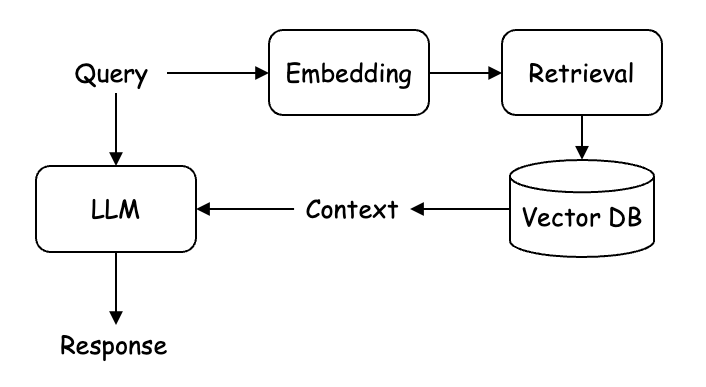

*Process flow of RAG-based LLM application. Image by author.*

In this guide, we're going to build an image question-answering application utilizing RAG and LLM from scratch. Our goal is to develop a system capable of answering queries using data from image-based sources like infographics, thereby tapping into the rich information embedded in images. Here are the main topics that we'll be covering:
- Image data preparation
- Context retrieval
- Response generation
- Applications
- Conclusion

# Set up

In [ ]:
import os
import ray
import warnings

warnings.filterwarnings("ignore")
from dotenv import load_dotenv

load_dotenv()

In [ ]:
# Initialize cluster
if ray.is_initialized():
    ray.shutdown()
ray.init(
    runtime_env={
        "env_vars": {
            "OPENAI_API_KEY": os.environ["OPENAI_API_KEY"],
        },
    }
)

In [ ]:
ray.cluster_resources()

In [ ]:
from imrag.constant import EMBEDDING_DIMENSIONS, MAX_CONTEXT_LENGTHS

In [ ]:
EMBEDDING_DIMENSIONS

In [ ]:
MAX_CONTEXT_LENGTHS

# Image data preparation

To use RAG in our LLM application, we must create a vector database to store processed information from our image data sources.

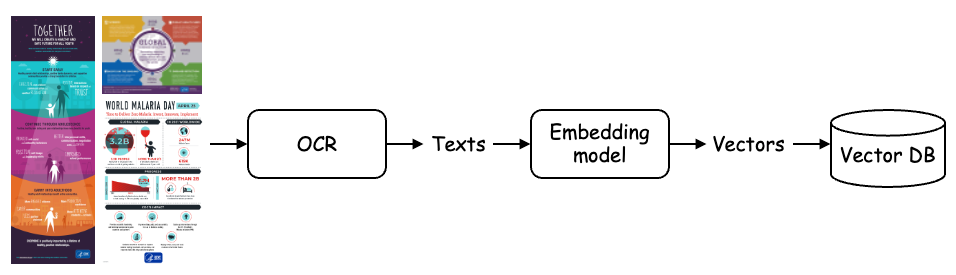

*The process of establishing a vector database. The infographics on the left were developed by [CDC](https://www.cdc.gov/) and can be downloaded on the [CDC's website](https://www.cdc.gov/globalhealth/infographics/default.html) free of charge.*

## Load data

We'll be utilizing infographics from CDC as our image data sources, but feel free to use any images of your choice. We will begin by saving these infographics locally, and load their paths into a Ray dataset for scalable processing.

In [ ]:
from pathlib import Path

In [ ]:
IMGS_DIR = Path("../data/")
ds = ray.data.from_items(
    [{"path": path.as_posix()} for path in IMGS_DIR.rglob("*.jpg") if not path.is_dir()]
)
print(f"{ds.count()} images")

## Extract texts from images

We'll then create a class to load images from our dataset and perform optical character recognition (OCR) to extract text from these images, as illustrated below.

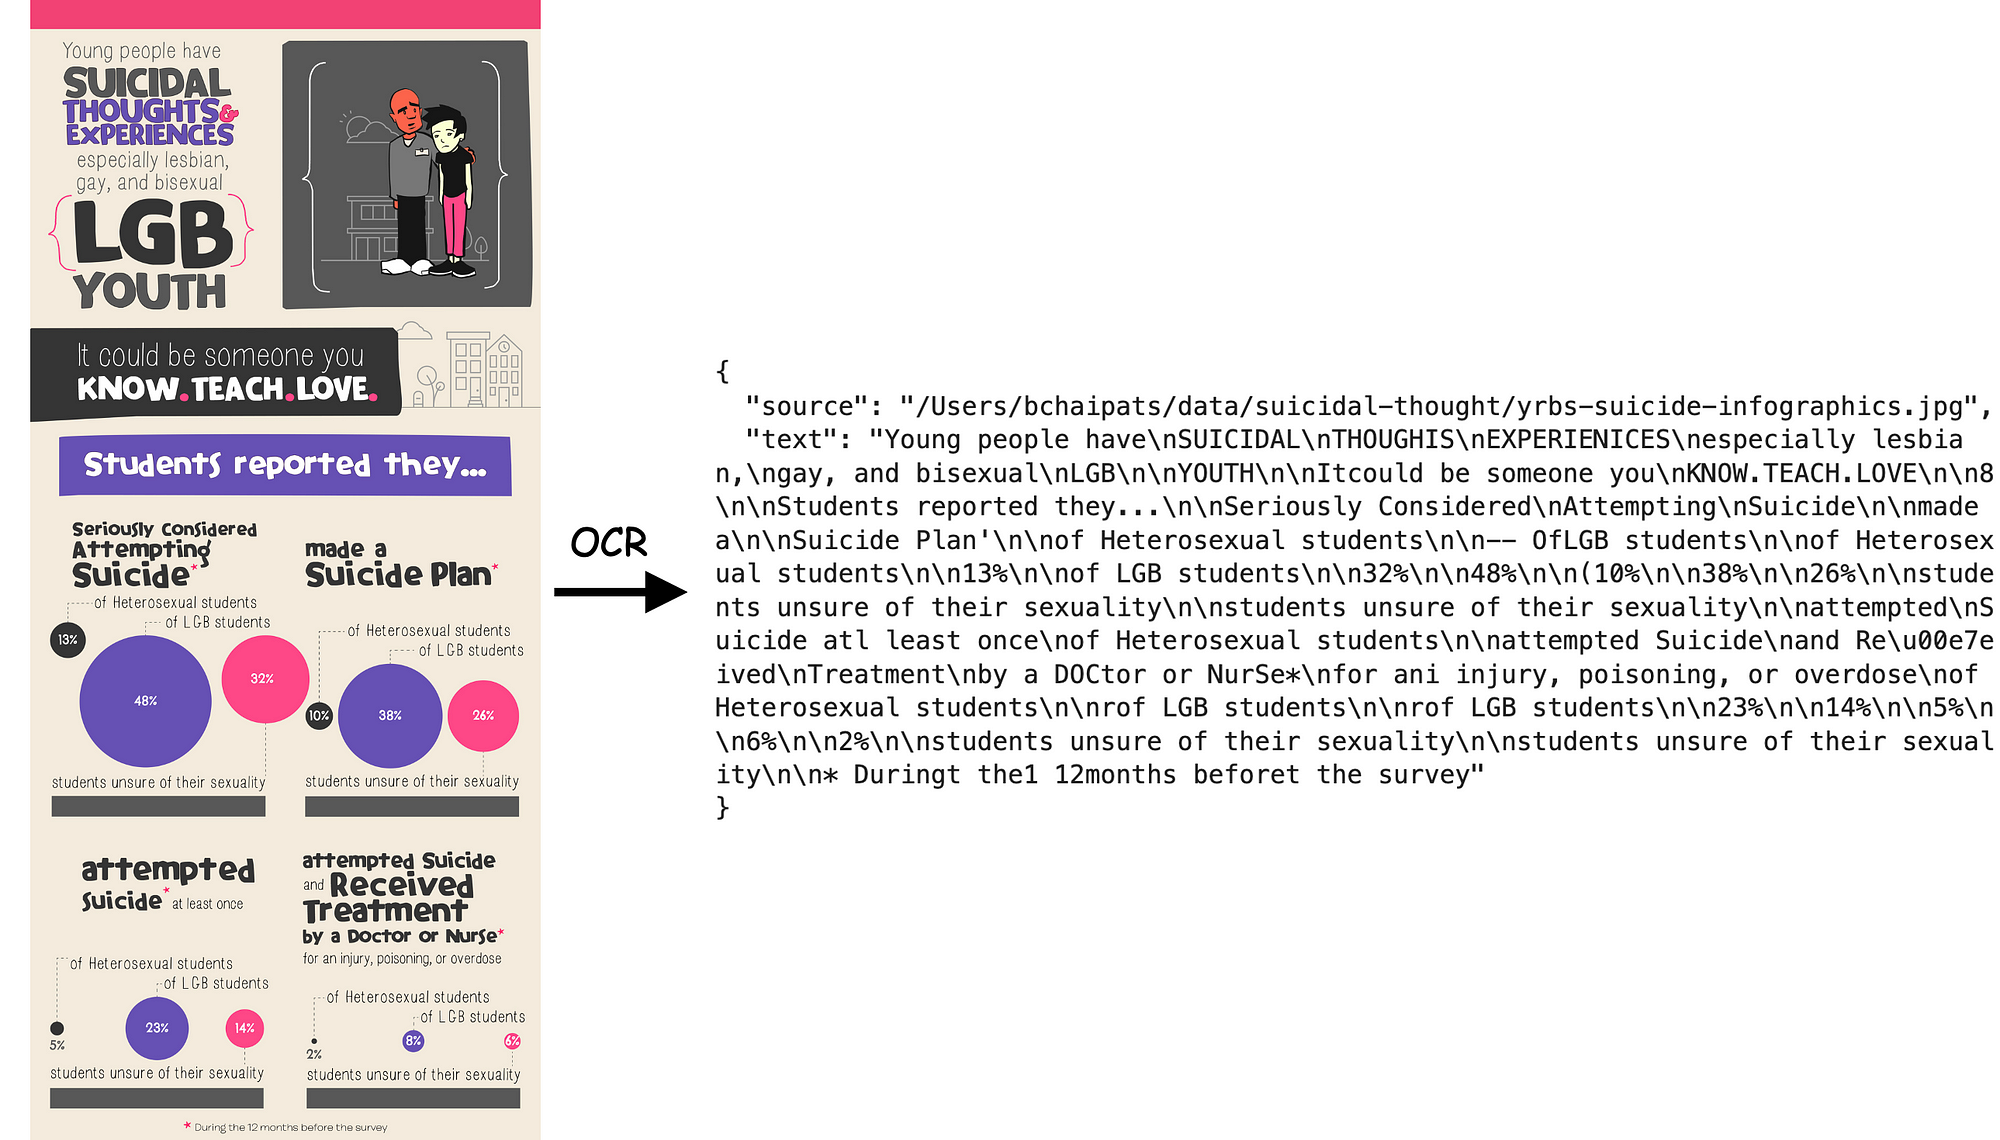

*Optical character recognition (OCR) is a technique used to identify and extract text from images. The infographic displayed on the left, sourced from the [CDC's website](https://www.cdc.gov/violenceprevention/communicationresources/infographics/yrbs-lgb-suicide.html), serves as an example.*

In the OCR tool landscape, docTR stands out as the best fit for our needs. It's a user-friendly, deep-learning based OCR system, complete with pre-trained models for text detection and recognition. Its ocr_predictor, a pipeline that combines a detector and recognizer, enables us to extract text from images with just one class call. Now, let's create a class to accomplish this.

In [ ]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

In [ ]:
class ExtractText:
    def __init__(self):
        self.ocr_model = ocr_predictor(pretrained=True)

    def __call__(self, batch):
        doc = DocumentFile.from_images(batch["path"])
        text = self.ocr_model(doc)
        return {"source": batch["path"], "text": [text.render()]}

Following that, we can use the map_batches method from the Ray dataset to apply the OCR process to all image paths in parallel.

In [ ]:
from ray.data import ActorPoolStrategy

In [ ]:
# Extract texts from images
texts_ds = ds.map_batches(ExtractText, compute=ActorPoolStrategy(size=2))

In [ ]:
sample = texts_ds.take(1)

In [ ]:
import json

In [ ]:
print(json.dumps(sample, indent=2))

## Embed texts

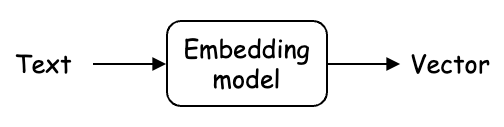

*Embedding text flow. Image by author.*

In this step, we will leverage a pre-trained embedding model to transform our image-derived text dataset into embedding vectors. These vectors encapsulate the semantic relationships of the words from the original texts. Later, we can compare these vectors with the embedding of a user query to identify the most relevant contexts. Now, let's create a class to embed texts.

In [ ]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

In [ ]:
class EmbedTexts:
    def __init__(self, model_name="thenlper/gte-base"):
        self.embedding_model = HuggingFaceEmbeddings(
            model_name=model_name,
            model_kwargs={"device": "cpu"},
            encode_kwargs={"device": "cpu", "batch_size": 4},
        )

    def __call__(self, batch):
        embeddings = self.embedding_model.embed_documents(batch["text"])
        return {
            "text": batch["text"],
            "source": batch["source"],
            "embeddings": embeddings,
        }

In [ ]:
embedded_texts = texts_ds.map_batches(
    EmbedTexts,
    fn_constructor_kwargs={"model_name": "thenlper/gte-base"},
    compute=ActorPoolStrategy(size=2),
)
sample = embedded_texts.take(1)
print(f"embedding size: {len(sample[0]['embeddings'])}")

## Store embeddings

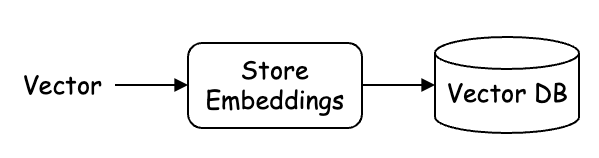

*Storing embedding flow. Image by author.*

In this step, we will create a vector database and populate it with our text embeddings. 

We'll use PostgreSQL for our database, which can be easily downloaded through Homebrew for Mac OS X users, or directly from the PostgreSQL download page. After installing PostgreSQL, we can utilize the psql command to install the pgvector extension. This handy extension allows us to store vectors and perform vector similarity searches in PostgreSQL.

```bash
psql -U postgres -c "CREATE EXTENSION vector;"
```

Likewise, we can execute another command to create a table for storing our embeddings, along with relevant information like original texts and source image paths.

```bash
psql -U postgres -c "CREATE TABLE infographic (id serial primary key, "text" text not null, source text not null, embedding vector(768))"
```

Now that we've set up our table, we'll create a class to connect and insert our processed data - texts, sources, and text embeddings - into the table.

In [ ]:
import psycopg
from pgvector.psycopg import register_vector


class StoreEmbeddings:
    def __call__(self, batch):
        with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
            register_vector(conn)
            with conn.cursor() as cur:
                for text, source, embedding in zip(
                    batch["text"], batch["source"], batch["embeddings"]
                ):
                    cur.execute(
                        "INSERT INTO infographic (text, source, embedding) VALUES (%s, %s, %s)",
                        (
                            text,
                            source,
                            embedding,
                        ),
                    )
        return {}

We then parallelize the insertion process on the embedded text dataset. We use the .count() function to kick-start the process, given that Ray's transformations like map_batches are inherently lazy.

In [ ]:
embedded_texts.map_batches(
    StoreEmbeddings,
    batch_size=4,
    num_cpus=1,
    compute=ActorPoolStrategy(size=2),
).count()

After this, we can examine the table to verify that it's populated with rows, each representing processed data for a unique infographic.

```bash
psql -U postgres -c "SELECT COUNT(*) FROM infographic"
```

# Context retrieval

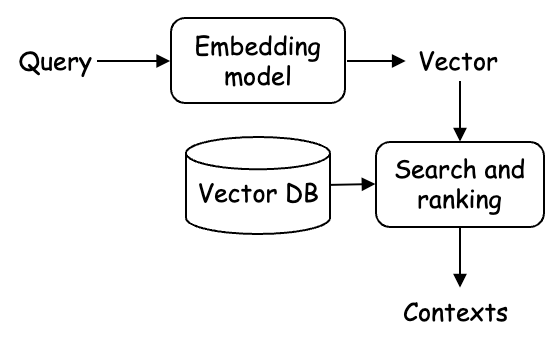

*Context retrieval flow. Image by author.*

In our system, we use a single embedding model to encode both user queries and infographics. When a question is asked, it's embedded and a nearest-neighbor search is performed. This step measures the cosine similarity between the query and infographic embeddings to identify the most relevant infographics.
Let's create a function to streamline the context retrieval process.

Let's create a function to streamline the context retrieval process.

In [ ]:
import numpy as np

In [ ]:
def semantic_search(query, embedding_model, num_infographics):
    question_embedding = np.array(embedding_model.embed_query(query))
    with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
        register_vector(conn)
        with conn.cursor() as cur:
            cur.execute(
                "SELECT id, source, text FROM infographic ORDER BY embedding <=> %s LIMIT %s",
                (question_embedding, num_infographics),
            )
            rows = cur.fetchall()
            semantic_context = [
                {"id": row[0], "source": row[1], "text": row[2]} for row in rows
            ]
    return semantic_context

By utilizing the cosine distance operator (≤=>) and the LIMIT function, we can easily fetch texts from infographic rows with embeddings that closely match the question embedding. Let's put this function to the test by posing a question and asking it to provide three relevant infographics as context.

In [ ]:
query = "How can we reduce violence against young people?"
embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-base")
num_infographics = 3
result = semantic_search(query, embedding_model, num_infographics)
print(json.dumps(result, indent=2))

# Response generation

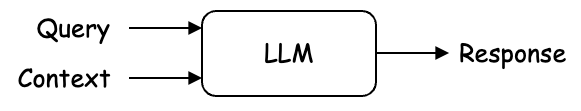

*Response generation flow. Image by author.*

In this final step, we'll create a function to generate responses to user queries using an LLM, utilizing OpenAI API's chat completion feature. You can get the necessary OpenAI API key from your user settings page. Now, let's create this function.

In [ ]:
import openai
import time


def generate_response(
    llm,
    temperature=0.0,
    system_content="",
    assistant_content="",
    user_content="",
    max_retries=1,
    retry_interval=60,
):
    """Generate response from an LLM."""
    retry_count = 0
    while retry_count <= max_retries:
        try:
            response = openai.ChatCompletion.create(
                model=llm,
                temperature=temperature,
                stream=False,
                api_key=os.environ["OPENAI_API_KEY"],
                messages=[
                    {"role": "system", "content": system_content},
                    {"role": "assistant", "content": assistant_content},
                    {"role": "user", "content": user_content},
                ],
            )
            return response["choices"][-1]["message"]["content"]
        except Exception as e:
            print(f"Exception: {e}")
            time.sleep(retry_interval)
            retry_count += 1
    return ""

Now that we're prepared, let's delve into the exciting part - generating responses to user queries with the large language model. We'll start with a simple question: **"How many malaria deaths occurred in 2021?"**.

In [ ]:
# Retrieve context
query = "How many malaria deaths are there in 2021?"
embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-base")
num_infographics = 1
results = semantic_search(query, embedding_model, num_infographics)
context = [item["text"] for item in results]

# Generate response
response = generate_response(
    llm="gpt-4",
    temperature=0.0,
    system_content="Answer the query using the context provided. Be succinct.",
    user_content=f"query: {query}, context: {context}",
)

# Stream response
for content in response:
    print(content, end="", flush=True)

In [ ]:
sources = [item["source"] for item in results]
print(sources)

Let's explore the infographic using its file path to discover any relevant insights.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
img = plt.imread(sources[0])
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

# Applications

In this section, I will outline a few applications of our implemented system, although this is not an exhaustive list.

## Question-answering

Throughout this guide, we've shown how simple it is to use our system for question-answering tasks. One crucial parameter to note is the 'num_infographics', which sets the number of infographics used as contexts. If set too low, the large language model (LLM) might lack the necessary information, but if set too high, it could be overwhelmed with noise, leading to inaccurate answers.

## Summarization

If we have multiple infographics on the same topic, we can ask the system to succinctly summarize interesting insights from them. For instance, the system can summarize key insights about violence from the three most relevant infographics.

In [ ]:
# Retrieve context
query = "Summarize interesting insights about violence."
embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-base")
num_infographics = 3
results = semantic_search(query, embedding_model, num_infographics)
context = [item["text"] for item in results]
sources = [item["source"] for item in results]

# Generate response
response = generate_response(
    llm="gpt-4",
    temperature=0.0,
    system_content="Answer the query using the context provided. Be succinct.",
    user_content=f"query: {query}, context: {context}",
)

# Print sources
print(f"Sources: {sources}\n")

# Stream response
print("Response:")
for content in response:
    print(content, end="", flush=True)

## Suggestions for infographic improvement

Another practical application is to have the system suggest enhancements for a specific infographic. For example, the system could propose more engaging content to augment the infographic on neonatal tetanus. It's important to note that 'num_infographics' is set to 1, allowing the system to suggest improvements based on the content of a single infographic.

In [ ]:
# Retrieve context
query = "Suggest more engaging information to enhance the infographic about neonatal tetanus."
embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-base")
num_infographics = (
    1  # Recommend this value for the infographic improvement suggestion use case.
)
results = semantic_search(query, embedding_model, num_infographics)
context = [item["text"] for item in results]
sources = [item["source"] for item in results]

# Generate response
response = generate_response(
    llm="gpt-4",
    temperature=0.0,
    system_content="Answer the query using the context provided. Be succinct.",
    user_content=f"query: {query}, context: {context}",
)

# Print sources
print(f"Sources: {sources}\n")

# Stream response
print("Response:")
for content in response:
    print(content, end="", flush=True)

# Plot image
img = plt.imread(sources[0])
plt.imshow(img)
plt.axis("off")
plt.show()

# Conclusion

In this tutorial, we have successfully built an image question-answering system using RAG and LLM. By providing the necessary context, the LLM model can accurately answer queries based on information extracted from image data sources. The process of building such a system, from text extraction from images to text embedding, context retrieval, and finally response generation, may seem complex, but with a clear understanding of the steps involved, it is entirely achievable. The potential applications of such a system are vast, opening up new possibilities for data analysis and information retrieval.

# Further improvement

You may have already noticed a significant issue with our system. If an infographic contains excessive text, it can result in an overly lengthy context, leaving no space for contexts from other infographics in the prompt message. This poses a problem if a question requires information from these other infographics, as the LLM may not be able to provide an answer due to insufficient context. A potential solution is chunking, a technique that breaks down the infographic's information into several segments. Each segment is then converted into a unique vector by the embedding model. During retrieval, only the chunks relevant to the question are retrieved, significantly reducing context noise. However, due to the high cohesion of infographic data, chunking must be done carefully to avoid issues. As a result, chunk size becomes an additional parameter to consider when performing chunking.
Finally, for those intending to create a production-grade RAG-based LLM application, I highly recommend reviewing "Building RAG-based LLM Applications for Production" by Goku Mohandas and Philipp Moritz. It has been an invaluable resource for me and this guide.

# Reference

- Building RAG-based LLM Applications for Production
- Centers for Disease Control and Prevention's (CDC) Infographics
- Ray's documentation
- docTR (Document Text Recognition) - a library for OCR-related tasks powered by Deep Learning
- pgvector - Open-source similarity search for PostgreSQL